In [1]:
import sympy
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, TensorSymmetry
from einsteinpy.symbolic import RicciTensor, RicciScalar, MetricTensor, ChristoffelSymbols

sympy.init_printing()

### Quadratic Action

First compute the action that is quadratic in the perturbations.

Start with the Ricci scalar.

In [2]:
syms = sympy.symbols("r psi theta phi")
r, psi, theta, phi = syms

In [3]:
L = sympy.symbols("L")  # AdS length scale
r_0 = sympy.symbols("r_0")

In [4]:
# perturbation of the spherical part of the metric
g_0 = sympy.Function('g_0')(r)
delta_g = sympy.Function('delta_g')(r)
g = g_0 + delta_g

In [5]:
# perturbation of radial part of the metric
f_0 = sympy.Function('f_0')(r)
delta_f = sympy.Function('delta_f')(r)
f = f_0 + delta_f

In [6]:
# perturbation of gauge field
Phi_0 = sympy.Function('Phi_0')(r)
delta_Phi = sympy.Function('delta_\Phi')(r)
Phi = Phi_0 + delta_Phi

In [7]:
list2d = [[0 for i in range(4)] for i in range(4)]
list2d[0][0] = 1 / f
list2d[1][1] = list2d[2][2] = list2d[3][3] = g / 4
list2d[1][3] = list2d[3][1] = g / 4 * sympy.cos(theta)
sch = MetricTensor(list2d, syms)
sch.tensor()

⎡      1                                                                      
⎢──────────────             0                   0                    0        
⎢δ_f(r) + f₀(r)                                                               
⎢                                                                             
⎢                    δ_g(r)   g₀(r)                       ⎛δ_g(r)   g₀(r)⎞    
⎢      0             ────── + ─────             0         ⎜────── + ─────⎟⋅cos
⎢                      4        4                         ⎝  4        4  ⎠    
⎢                                                                             
⎢                                         δ_g(r)   g₀(r)                      
⎢      0                    0             ────── + ─────             0        
⎢                                           4        4                        
⎢                                                                             
⎢                ⎛δ_g(r)   g₀(r)⎞                   

In [8]:
Ric = RicciTensor.from_metric(sch)

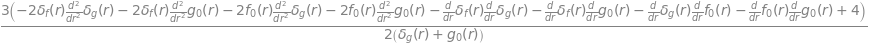

In [9]:
R = RicciScalar.from_riccitensor(Ric)
R.simplify()
R.expr

Next compute the Maxwell field contribution to the action.

In [10]:

A_1 = L / 2 * Phi * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * Phi * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * Phi * sympy.Array([0, 1, 0, sympy.cos(theta)])

In [11]:
A_1, A_2, A_3

⎛⎡      -L⋅(Φ₀(r) + δ_\Phi(r))⋅sin(ψ)   L⋅(Φ₀(r) + δ_\Phi(r))⋅sin(θ)⋅cos(ψ)⎤  
⎜⎢0  0  ──────────────────────────────  ───────────────────────────────────⎥, 
⎝⎣                    2                                  2                 ⎦  

⎡      L⋅(Φ₀(r) + δ_\Phi(r))⋅cos(ψ)  L⋅(Φ₀(r) + δ_\Phi(r))⋅sin(ψ)⋅sin(θ)⎤  ⎡  
⎢0  0  ────────────────────────────  ───────────────────────────────────⎥, ⎢0 
⎣                   2                                 2                 ⎦  ⎣  

 L⋅(Φ₀(r) + δ_\Phi(r))     L⋅(Φ₀(r) + δ_\Phi(r))⋅cos(θ)⎤⎞
 ─────────────────────  0  ────────────────────────────⎥⎟
           2                            2              ⎦⎠

In [12]:
x = [r, psi, theta, phi]
def em_field_strength(A):
    """Compute EM field strength from the vector potential."""    
    F = sympy.MutableDenseNDimArray.zeros(4, 4)
    for i in range(4):
        for j in range(4):
            F[i, j] = sympy.diff(A[j], x[i]) - sympy.diff(A[i], x[j])
    return F

In [13]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

In [14]:
metric_inv = sympy.simplify(sympy.Matrix(list2d).inv())
metric_inv

⎡δ_f(r) + f₀(r)             0                    0                    0       
⎢                                                                             
⎢                           4                                     -4⋅cos(θ)   
⎢      0         ────────────────────────        0         ───────────────────
⎢                                    2                                        
⎢                (δ_g(r) + g₀(r))⋅sin (θ)                  (δ_g(r) + g₀(r))⋅si
⎢                                                                             
⎢                                                4                            
⎢      0                    0              ──────────────             0       
⎢                                          δ_g(r) + g₀(r)                     
⎢                                                                             
⎢                       -4⋅cos(θ)                                     4       
⎢      0         ────────────────────────        0  

In [15]:
Euclidean = TensorIndexType('Euclidean', dummy_name='E')
i0, i1, i2, i3, i4, i5, i6, i7 = tensor_indices('i0:8', Euclidean)

In [16]:
FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv, metric_inv)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}

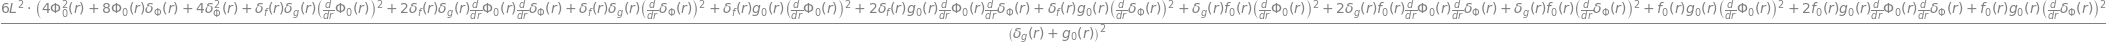

In [17]:
FF_contracted = sympy.simplify(FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl))
FF_contracted

Compute the metric determinant.

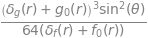

In [18]:
det_g = sympy.Matrix(sch.tensor()).det().simplify()
det_g

Get the integrand of the on-shell action.

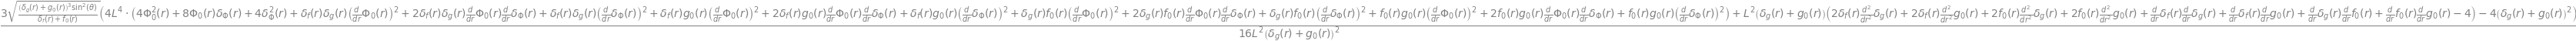

In [19]:
on_shell_action_integrand = -sympy.sqrt(det_g) * (R.expr + 6 / L ** 2 - FF_contracted)
on_shell_action_integrand.simplify()

Get the equations of motion that can be removed from the integrand.

In [20]:
list2d_2 = [[0 for i in range(4)] for i in range(4)]
list2d_2[0][0] = 1 / f_0
list2d_2[1][1] = list2d_2[2][2] = list2d[3][3] = g_0 / 4
list2d_2[1][3] = list2d_2[3][1] = g_0 / 4 * sympy.cos(theta)
sch_2 = MetricTensor(list2d_2, syms)
sch_2.tensor()

⎡  1                                     ⎤
⎢─────       0          0         0      ⎥
⎢f₀(r)                                   ⎥
⎢                                        ⎥
⎢          g₀(r)             g₀(r)⋅cos(θ)⎥
⎢  0       ─────        0    ────────────⎥
⎢            4                    4      ⎥
⎢                                        ⎥
⎢                     g₀(r)              ⎥
⎢  0         0        ─────       0      ⎥
⎢                       4                ⎥
⎢                                        ⎥
⎢       g₀(r)⋅cos(θ)                     ⎥
⎢  0    ────────────    0         0      ⎥
⎣            4                           ⎦

In [21]:
Ric_2 = RicciTensor.from_metric(sch_2)
Ric_2.tensor().simplify()

⎡      2                                                                      
⎢     d                        2                                              
⎢  3⋅───(g₀(r))     ⎛d        ⎞      d         d                              
⎢      2          3⋅⎜──(g₀(r))⎟    3⋅──(f₀(r))⋅──(g₀(r))                      
⎢    dr             ⎝dr       ⎠      dr        dr                             
⎢- ──────────── + ────────────── - ─────────────────────                      
⎢    2⋅g₀(r)             2             4⋅f₀(r)⋅g₀(r)                          
⎢                    4⋅g₀ (r)                                                 
⎢                                                                             
⎢                                                                            2
⎢                                                                           d 
⎢                                                                    f₀(r)⋅───
⎢                                                   

In [22]:
metric_array = sympy.MutableDenseNDimArray(list2d_2)
einstein_tensor = sympy.MutableDenseNDimArray(Ric_2.tensor()) + 3 / L ** 2 * metric_array
einstein_tensor = sympy.simplify(einstein_tensor)
einstein_tensor

⎡      2                                                                      
⎢     d                        2                                              
⎢  3⋅───(g₀(r))     ⎛d        ⎞      d         d                              
⎢      2          3⋅⎜──(g₀(r))⎟    3⋅──(f₀(r))⋅──(g₀(r))                      
⎢    dr             ⎝dr       ⎠      dr        dr             3               
⎢- ──────────── + ────────────── - ───────────────────── + ────────           
⎢    2⋅g₀(r)             2             4⋅f₀(r)⋅g₀(r)        2                 
⎢                    4⋅g₀ (r)                              L ⋅f₀(r)           
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [23]:
A_1 = L / 2 * Phi_0 * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * Phi_0 * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * Phi_0 * sympy.Array([0, 1, 0, sympy.cos(theta)])
A_1, A_2, A_3

⎛⎡      -L⋅Φ₀(r)⋅sin(ψ)   L⋅Φ₀(r)⋅sin(θ)⋅cos(ψ)⎤  ⎡      L⋅Φ₀(r)⋅cos(ψ)  L⋅Φ₀(
⎜⎢0  0  ────────────────  ─────────────────────⎥, ⎢0  0  ──────────────  ─────
⎝⎣             2                    2          ⎦  ⎣            2              

r)⋅sin(ψ)⋅sin(θ)⎤  ⎡   L⋅Φ₀(r)     L⋅Φ₀(r)⋅cos(θ)⎤⎞
────────────────⎥, ⎢0  ───────  0  ──────────────⎥⎟
     2          ⎦  ⎣      2              2       ⎦⎠

In [24]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

In [25]:
metric_inv_2 = sympy.simplify(sympy.Matrix(list2d_2).inv())
metric_inv_2

⎡f₀(r)       0          0          0      ⎤
⎢                                         ⎥
⎢                                 4       ⎥
⎢  0         0          0    ──────────── ⎥
⎢                            g₀(r)⋅cos(θ) ⎥
⎢                                         ⎥
⎢                       4                 ⎥
⎢  0         0        ─────        0      ⎥
⎢                     g₀(r)               ⎥
⎢                                         ⎥
⎢            4                    -4      ⎥
⎢  0    ────────────    0    ─────────────⎥
⎢       g₀(r)⋅cos(θ)                  2   ⎥
⎣                            g₀(r)⋅cos (θ)⎦

In [26]:
FFg_tensor = TensorHead('FFg', [Euclidean] * 6)
FFg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv_2) +
    sympy.tensorproduct(F_2, F_2, metric_inv_2) +
    sympy.tensorproduct(F_3, F_3, metric_inv_2)
)
repl = {FFg_tensor(-i0, -i1, -i2, -i3, i4, i5): FFg_matrix}
T_contracted_1 = FFg_tensor(-i0, -i1, -i2, -i3, i3, i1).replace_with_arrays(repl)
T_contracted_1 = sympy.simplify(T_contracted_1)

FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv_2, metric_inv_2) +
    sympy.tensorproduct(F_2, F_2, metric_inv_2, metric_inv_2) +
    sympy.tensorproduct(F_3, F_3, metric_inv_2, metric_inv_2)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}
T_contracted_2 = FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl)
T_contracted_2 = sympy.simplify(T_contracted_2)

In [27]:
energy_momentum = 2 * (T_contracted_1 - metric_array / 4 * T_contracted_2)
energy_momentum = sympy.simplify(energy_momentum)
energy_momentum

⎡   ⎛                                                                         
⎢   ⎜                                                                  ⎛d     
⎢   ⎜                  2                               2   f₀(r)⋅g₀(r)⋅⎜──(Φ₀(
⎢ 2 ⎜       2      8⋅Φ₀ (r)                 ⎛d        ⎞                ⎝dr    
⎢L ⋅⎜- 12⋅Φ₀ (r) + ──────── + 3⋅f₀(r)⋅g₀(r)⋅⎜──(Φ₀(r))⎟  - ───────────────────
⎢   ⎜                 2                     ⎝dr       ⎠               2       
⎢   ⎝              cos (θ)                                         cos (θ)    
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                            2                                
⎢                                    f₀(r)⋅g₀ (r)                             
⎢                                                                             
⎢                                                                             
⎢                                                   

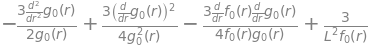

In [28]:
einstein_tensor[0, 0]

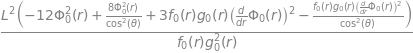

In [29]:
energy_momentum[0, 0]

Compute the extrinsic curvature on the boundary.

In [30]:
gn_tensor = TensorHead('gn', [Euclidean] * 3)
repl = {gn_tensor(-i0, -i1, i2): sympy.tensorproduct(list2d, [1, 0, 0, 0])}
n_lower = sympy.simplify(gn_tensor(-i0, -i1, i1).replace_with_arrays(repl))
n_lower

⎡      1                ⎤
⎢──────────────  0  0  0⎥
⎣δ_f(r) + f₀(r)         ⎦

In [31]:
ch = ChristoffelSymbols.from_metric(sch)
ch = ch.tensor().simplify()
ch

⎡⎡  d            d                                                            
⎢⎢- ──(δ_f(r)) - ──(f₀(r))                                                    
⎢⎢  dr           dr                                                           
⎢⎢────────────────────────                          0                         
⎢⎢   2⋅(δ_f(r) + f₀(r))                                                       
⎢⎢                                                                            
⎢⎢                                               ⎛d            d        ⎞     
⎢⎢                             -(δ_f(r) + f₀(r))⋅⎜──(δ_g(r)) + ──(g₀(r))⎟     
⎢⎢                                               ⎝dr           dr       ⎠     
⎢⎢           0                 ───────────────────────────────────────────    
⎢⎢                                                  8                         
⎢⎢                                                                            
⎢⎢                                                  

In [32]:
x = [r, psi, theta, phi]
partial_n = sympy.MutableDenseNDimArray.zeros(4, 4)
for i in range(4):
    for j in range(4):
            partial_n[i, j] = sympy.diff(n_lower[j], x[i]) 
partial_n

⎡  d            d                 ⎤
⎢- ──(δ_f(r)) - ──(f₀(r))         ⎥
⎢  dr           dr                ⎥
⎢────────────────────────  0  0  0⎥
⎢                   2             ⎥
⎢   (δ_f(r) + f₀(r))              ⎥
⎢                                 ⎥
⎢           0              0  0  0⎥
⎢                                 ⎥
⎢           0              0  0  0⎥
⎢                                 ⎥
⎣           0              0  0  0⎦

In [33]:
lambda_n_tensor = TensorHead('lambdan', [Euclidean] * 4)
repl = {lambda_n_tensor(i0, -i1, -i2, -i3): sympy.tensorproduct(ch, n_lower)}
partial_n -= lambda_n_tensor(i0, -i1, -i2, -i0).replace_with_arrays(repl)
partial_n = sympy.simplify(partial_n)
partial_n

⎡  d            d                                                             
⎢- ──(δ_f(r)) - ──(f₀(r))                                                     
⎢  dr           dr                                                            
⎢────────────────────────                 0                           0       
⎢                    2                                                        
⎢  2⋅(δ_f(r) + f₀(r))                                                         
⎢                                                                             
⎢                              d            d                                 
⎢                              ──(δ_g(r))   ──(g₀(r))                         
⎢                              dr           dr                                
⎢           0                  ────────── + ─────────                 0       
⎢                                  8            8                             
⎢                                                   

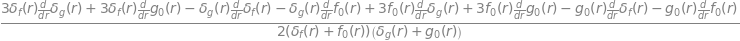

In [34]:
g_partial_n_tensor = TensorHead('gpartialn', [Euclidean] * 4)
repl = {g_partial_n_tensor(i0, i1, -i2, -i3): sympy.tensorproduct(metric_inv, partial_n)}
K = sympy.simplify(g_partial_n_tensor(i0, i1, -i0, -i1).replace_with_arrays(repl))
K

In [35]:
induced_metric_list = [[0 for i in range(3)] for i in range(3)]
induced_metric_list[0][0] = induced_metric_list[1][1] = induced_metric_list[2][2] = g / 4
induced_metric_list[0][2] = induced_metric_list[2][0] = g / 4 * sympy.cos(theta)
induced_metric = MetricTensor(induced_metric_list, (psi, theta, phi))
induced_metric.tensor()

⎡    δ_g(r)   g₀(r)                       ⎛δ_g(r)   g₀(r)⎞       ⎤
⎢    ────── + ─────             0         ⎜────── + ─────⎟⋅cos(θ)⎥
⎢      4        4                         ⎝  4        4  ⎠       ⎥
⎢                                                                ⎥
⎢                         δ_g(r)   g₀(r)                         ⎥
⎢           0             ────── + ─────             0           ⎥
⎢                           4        4                           ⎥
⎢                                                                ⎥
⎢⎛δ_g(r)   g₀(r)⎞                             δ_g(r)   g₀(r)     ⎥
⎢⎜────── + ─────⎟⋅cos(θ)        0             ────── + ─────     ⎥
⎣⎝  4        4  ⎠                               4        4       ⎦

In [36]:
det_h = sympy.Matrix(induced_metric.tensor()).det().simplify()
det_h

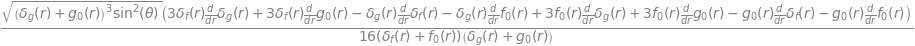

In [37]:
ghy_term = sympy.sqrt(det_h) * K
ghy_term.simplify()